# 유튜브 마케팅을 위한 유료광고영상의 성공 사례 분석
    - Analyzing the best practices of paid video for YouTube marketing

In [15]:
# Data Structure
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text Analysis
from wordcloud import WordCloud
from collections import Counter, defaultdict
from konlpy.tag import Okt

# Vision
from google.cloud import vision
from PIL import Image

# System
import io
import os
from io import BytesIO

# Access the internet
from urllib.request import urlopen
import requests

# Explore the Data

In [16]:
df = pd.read_csv('data_sample.csv')
df['publishDate'] = pd.to_datetime(df['publishDate'])

In [17]:
# tag열을 하나로 합침
df['tag1'] = df['tag1'].fillna('')
df['tag2'] = df['tag2'].fillna('')
df['tag3'] = df['tag3'].fillna('')

df['tag'] = df['tag1'] + ',' + df['tag2'] + ',' + df['tag3']
df['tag'] = df['tag'].str.strip(',')
df['tag'] = df['tag'].str.strip()
df['tag'] = df['tag'].str.split(',')

# tag 피쳐 남기고 버림
df.drop(columns=['tag1', 'tag2', 'tag3'], axis=1, inplace=True)

### 결측값 확인
    - likes, subscribers, totalViews, ch_avg_views는 결측값이 1% 미만이므로 데이터 제거

In [18]:
df.isna().sum()

video_url                 0
title                     0
channel_id                0
views                     0
likes                    37
video_thumbnails_url      0
publishDate               0
genre                     0
ads_yn                    0
duration_seconds          0
subscribers              74
totalViews               74
ch_avg_views            137
tag                       0
dtype: int64

In [19]:
# 다시 데이터 확인
df = df.dropna()
df.isna().sum()

video_url               0
title                   0
channel_id              0
views                   0
likes                   0
video_thumbnails_url    0
publishDate             0
genre                   0
ads_yn                  0
duration_seconds        0
subscribers             0
totalViews              0
ch_avg_views            0
tag                     0
dtype: int64

### 0값 확인
    - views, likes, ads_yn 의 0값은 의미가 있음.
    - 그러나, subscribers, totalViews, ch_avg_views 에서의 0값은 크롤링 문제거나 비공개로 판단함.
    - 따라서, subscribers, totalViews, ch_avg_views가 0값 인 것만 삭제

In [22]:
(df==0).sum()

video_url                   0
title                       0
channel_id                  0
views                      46
likes                    8620
video_thumbnails_url        0
publishDate                 0
genre                       0
ads_yn                  48197
duration_seconds            0
subscribers                 0
totalViews                  0
ch_avg_views                0
tag                         0
dtype: int64

In [21]:
# 구독자, 전체 조회수, 평균 조회 수가 하나라도 0이면 그 데이터 삭제
df = df[~((df['subscribers']==0)|(df['totalViews']==0)|(df['ch_avg_views']==0))]
df.reset_index(drop=True, inplace=True)
df.head(1)

video_url                  title  \
0  https://www.youtube.com/watch?v=u5ZsORGmaYU  [타로상담] 지금 이순간 그남자 속마음   

                 channel_id  views  likes  \
0  UC92vNke7kje_1ryaFUTbZpQ  17685  761.0   

                               video_thumbnails_url publishDate  \
0  https://i.ytimg.com/vi/u5ZsORGmaYU/hqdefault.jpg  2022-10-04   

            genre  ads_yn  duration_seconds  subscribers  totalViews  \
0  People & Blogs       0              1598      35600.0  12041966.0   

   ch_avg_views                      tag  
0       35839.0  [괴담 & 운세, 운세 & 오컬트, 종교]

# Feature Engineering
    - 하이픈이 정의한 태그1,2,3 중 2,3에 결측값이 많아 tag로 모두 합쳐버림
    - 장르 비율, 업로드 된 시간 피처 추가
    - 최신 영상(5일 미만) 은 비교 대상에서 제외함 - 미성숙한 영상으로 비교가 불공평하다고 판단 
    - 조회수 증가율이 완만해지는 평균 시점: 4.3일

In [25]:
# genre weight columns 추가
genre_counts = df['genre'].value_counts()

# 각 장르의 비율을 계산
df['genre_weight'] = df['genre'].apply(lambda x: genre_counts[x] / len(df))

In [26]:
# 업로드 된 지 며칠되었는지
df['date_from_recent'] = (max(df['publishDate']) - df['publishDate']).apply(lambda x: x.days)
df['date_from_recent'] = df['date_from_recent'].astype(float)

In [27]:
# 업로드 된 지 몇 주 되었는지
df['date_from_recent_week'] = ((max(df['publishDate']) - df['publishDate'] )/7).apply(lambda x: x.days)
df['date_from_recent_week'] = df['date_from_recent_week'].astype(float)
df['date_from_recent_week'] = df['date_from_recent_week'].apply(lambda x: np.trunc(x))

In [28]:
# 최신 영상(5일 미만) 은 비교 대상에서 제외
df = df[df['date_from_recent'] > 5]
df.reset_index(drop=True, inplace=True)

# 유료 광고 포함 영상 선별
    - score = 영상의 조회 수 / 채널의 평균 조회 수
    - score가 평균 이상이면 유료 광고에서 성공한 영상이라고 볼 수 있음
    - good_ad_df: 성공한 유료 광고 영상

In [31]:
# 전체 광고 영상
ad_df = df[df['ads_yn']==1]
ad_df = ad_df.copy()
ad_df['score'] = ad_df['views'] / ad_df['ch_avg_views']
ad_df = ad_df.sort_values(by='score', ascending=False)

# 성공한 광고 영상
good_ad_df = ad_df[ad_df['score'] > ad_df['score'].mean()]
good_ad_df.reset_index(drop=True, inplace=True)

In [64]:
ad_df.groupby('genre').size()

genre
Autos & Vehicles        137
Comedy                   62
Education               101
Entertainment           102
Film & Animation          7
Gaming                  454
Howto & Style           216
Music                    62
News & Politics           9
People & Blogs          216
Pets & Animals           20
Science & Technology     35
Sports                   95
Travel & Events          57
dtype: int64

In [65]:
good_ad_df.groupby('genre').size()

genre
Autos & Vehicles         41
Comedy                   18
Education                19
Entertainment            27
Film & Animation          1
Gaming                  199
Howto & Style            60
Music                     9
News & Politics           2
People & Blogs           56
Pets & Animals            3
Science & Technology      5
Sports                   34
Travel & Events          17
dtype: int64

In [32]:
ad_df['score'].describe()

count    1573.000000
mean        0.535745
std         1.461111
min         0.000286
25%         0.139564
50%         0.323001
75%         0.649597
max        53.099050
Name: score, dtype: float64

### 장르 별 Score 분포

In [33]:
pd.set_option('display.max_rows', 200)
good_ad_df.groupby('genre').describe()['score']

count       mean       min       25%       50%  \
genre                                                                  
Autos & Vehicles       41.0   1.556956  0.552684  0.738503  0.915468   
Comedy                 18.0   0.938790  0.550139  0.667237  0.767061   
Education              19.0   1.130428  0.544276  0.596379  0.734331   
Entertainment          27.0   1.180976  0.549971  0.793420  1.089500   
Film & Animation        1.0   0.744795  0.744795  0.744795  0.744795   
Gaming                199.0   1.050491  0.541269  0.686173  0.854855   
Howto & Style          60.0   1.069880  0.560479  0.716771  0.926427   
Music                   9.0   1.603587  0.538407  0.852226  1.018492   
News & Politics         2.0   1.019724  0.951054  0.985389  1.019724   
People & Blogs         56.0   1.179603  0.538425  0.691539  0.859299   
Pets & Animals          3.0  18.139698  0.657390  0.660023  0.662655   
Science & Technology    5.0   1.461174  0.724681  0.727796  1.569819   
Sports                 34.0   0.886718  0.545700  0.695051  0.848112   
Travel & Events        17.0   1.247048  0.551666  0.691328  1.033997   

                            75%        max        std  
genre                                                  
Autos & Vehicles       1.553058   9.725421   1.711036  
Comedy                 1.187926   2.301384   0.428644  
Education              1.181704   3.223307   0.825422  
Entertainment          1.348942   2.557159   0.568589  
Film & Animation       0.744795   0.744795        NaN  
Gaming                 1.271324   3.405887   0.525297  
Howto & Style          1.171186   4.073134   0.586637  
Music                  2.289021   3.667278   1.089100  
News & Politics        1.054060   1.088395   0.097115  
People & Blogs         1.394676   4.301910   0.754605  
Pets & Animals        26.880853  53.099050  30.275687  
Science & Technology   1.690741   2.592834   0.778689  
Sports                 0.956562   2.293865   0.331152  
Travel & Events        1.248700   4.043345   0.927041

### 인기 광고영상의 장르 별 영상길이의 중앙값
    - 이상치가 많아서 median 사용

In [35]:
# 영상 길이를 분으로 바꿈
good_ad_df['duration_min'] = round(good_ad_df['duration_seconds']/60,2)
good_ad_df.drop(columns='duration_seconds', inplace=True, axis=1)

C:\Users\7info\AppData\Local\Temp\ipykernel_25024\1680604042.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_ad_df['duration_min'] = round(good_ad_df['duration_seconds']/60,2)
C:\Users\7info\AppData\Local\Temp\ipykernel_25024\1680604042.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_ad_df.drop(columns='duration_seconds', inplace=True, axis=1)


In [37]:
# 영상 길이 분포
good_ad_df.groupby('genre')['duration_min'].median()

genre
Autos & Vehicles          8.230
Comedy                   12.115
Education                28.580
Entertainment            16.220
Film & Animation          5.480
Gaming                    9.830
Howto & Style            18.545
Music                     9.150
News & Politics         107.930
People & Blogs           17.575
Pets & Animals            0.820
Science & Technology     12.080
Sports                   13.550
Travel & Events          14.350
Name: duration_min, dtype: float64

---

# 영상 제목 텍스트 분석

In [58]:
# Word Cloud 생성
def plot_wordcloud(df, text_column, font_path='NanumGothic', grouped=True):
    plt.rc('font', family='Malgun Gothic')
    
    if not grouped:
        text = ' '.join(df[text_column])

        wordcloud = WordCloud(width=1200, height=800, background_color='white', font_path=font_path).generate(text)

        plt.figure(figsize=(10, 10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'전체 유료광고', fontsize=20)
        plt.show()
    else:
        for i in df['genre'].unique():
    
            cluster_data = df[df['genre'] == i]
            text = ' '.join(cluster_data[text_column])
    
            wordcloud = WordCloud(width=1200, height=800, background_color='white', font_path=font_path).generate(text)
    
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'{i}', fontsize=20)
            plt.tight_layout()
            plt.show()

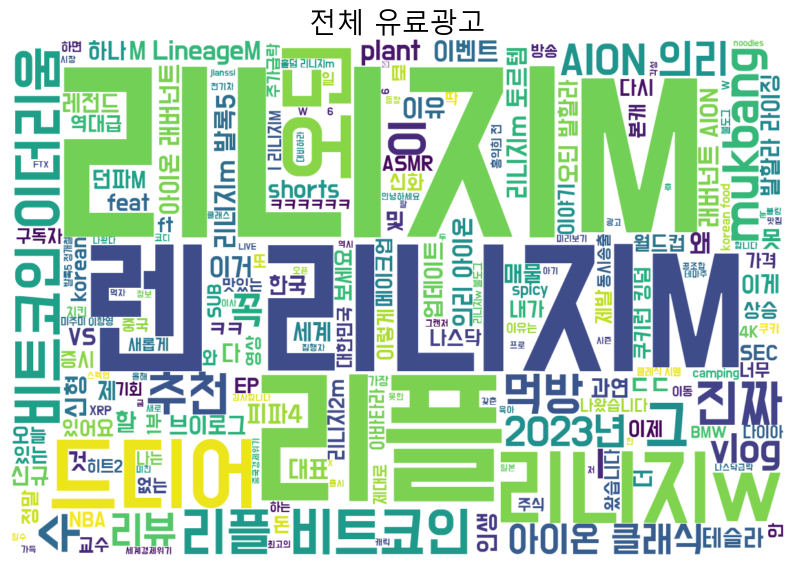

In [59]:
# 전체 유료광고영상에 대한 word cloud
plot_wordcloud(good_ad_df, 'title', font_path='BMDOHYEON_ttf.ttf', grouped=False)

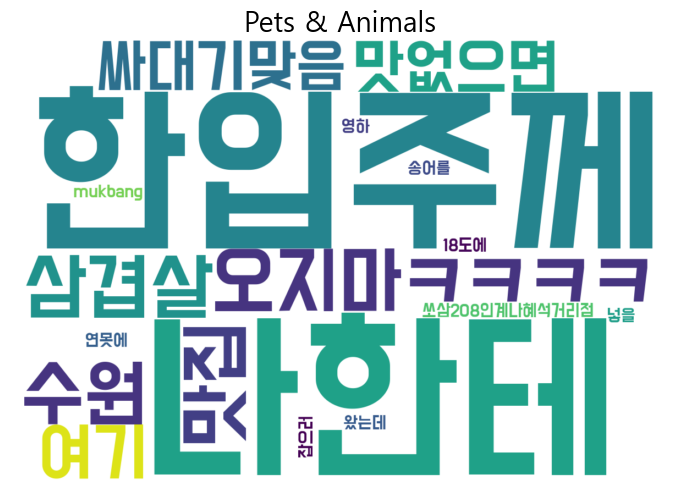

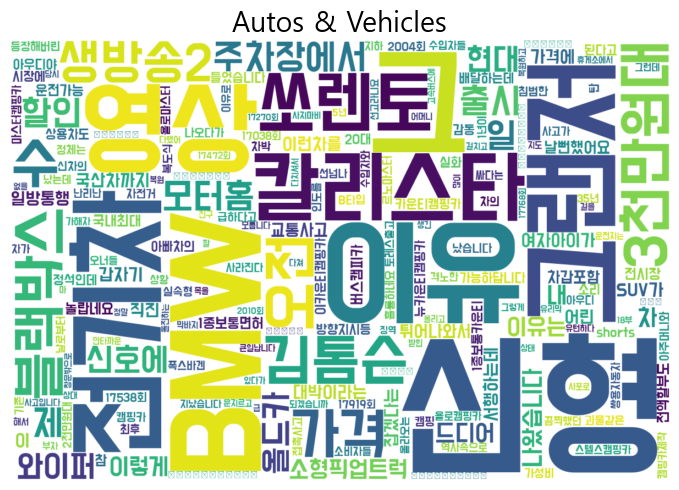

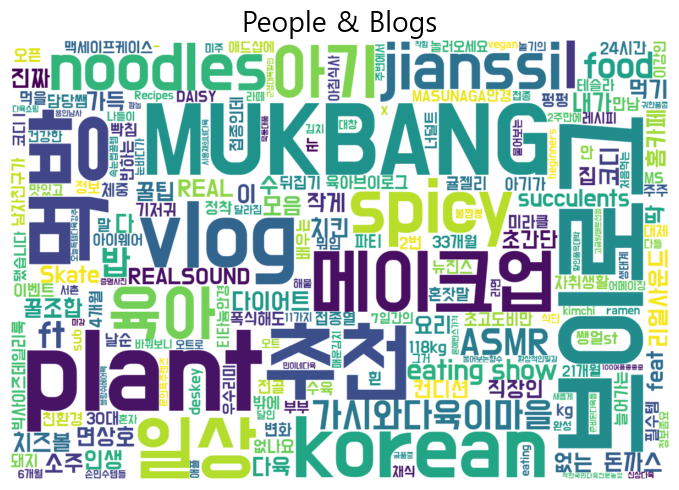

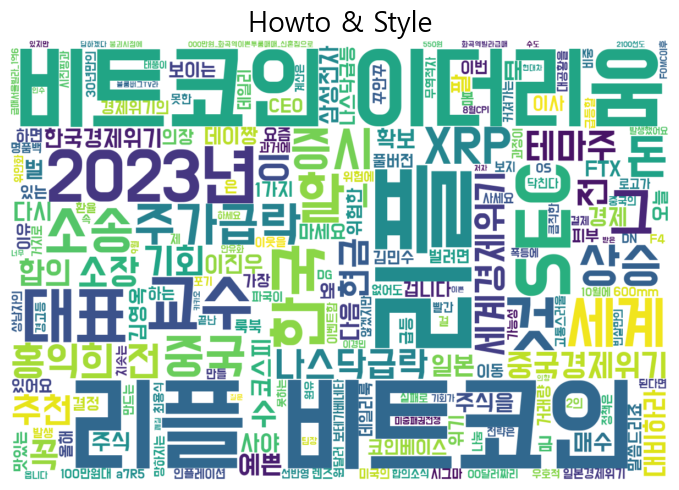

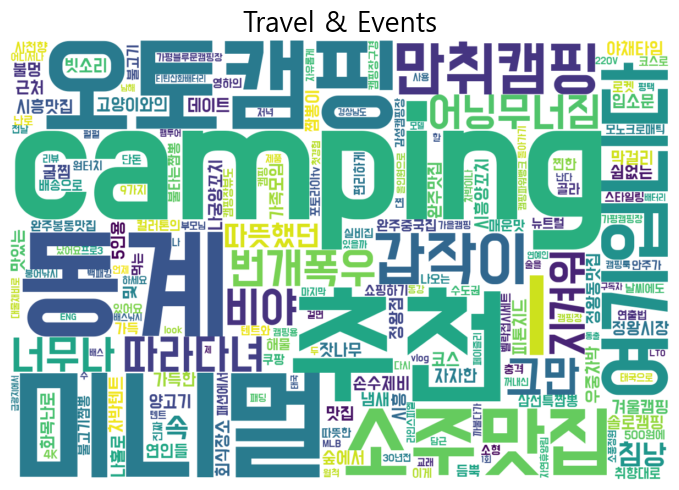

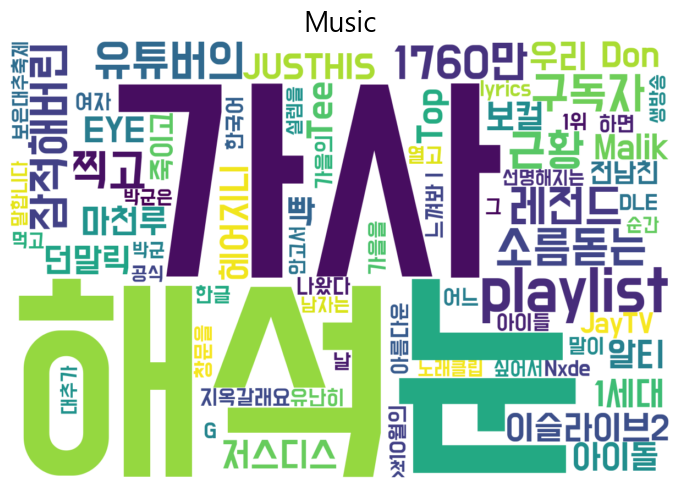

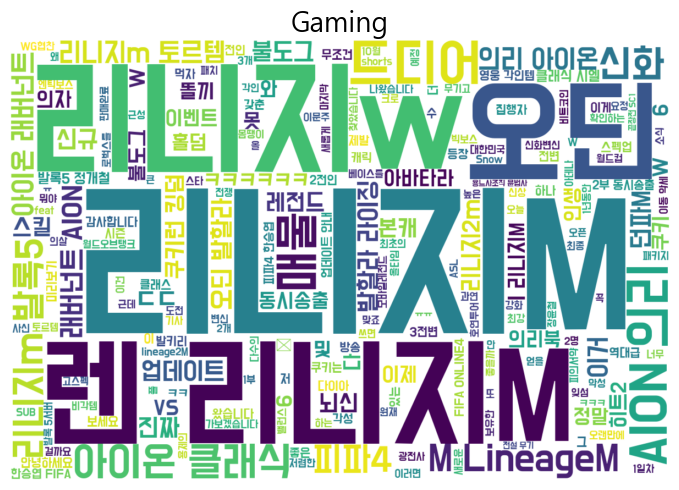

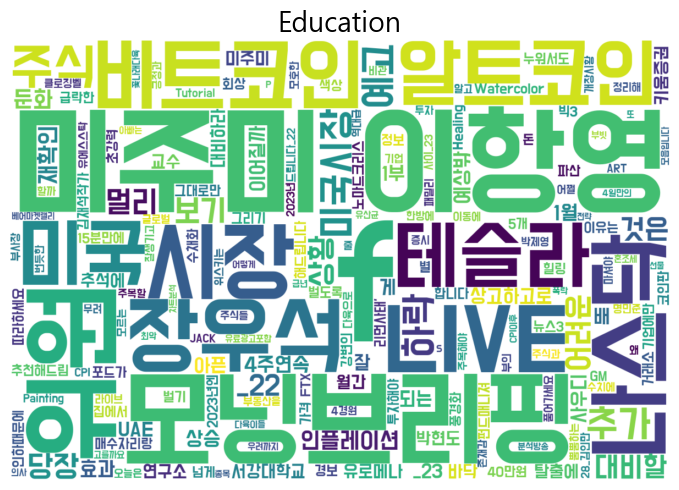

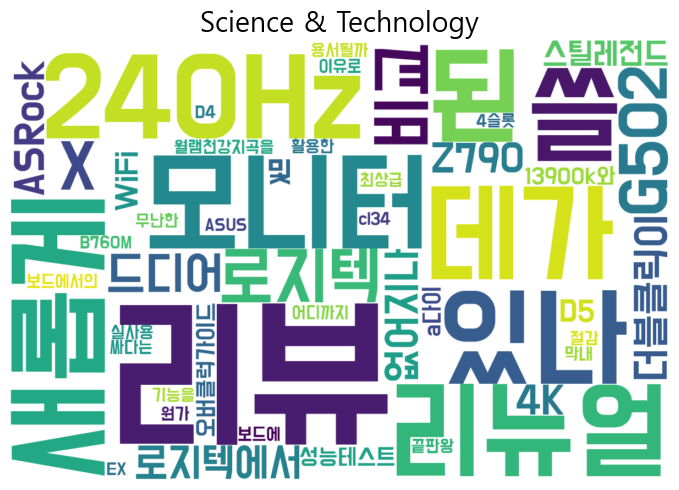

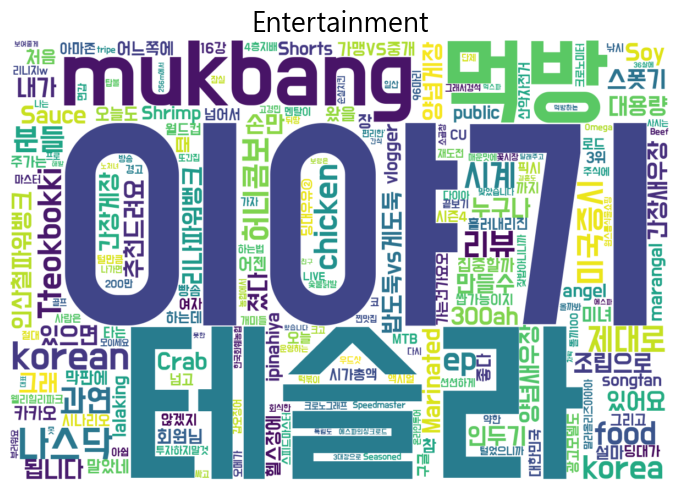

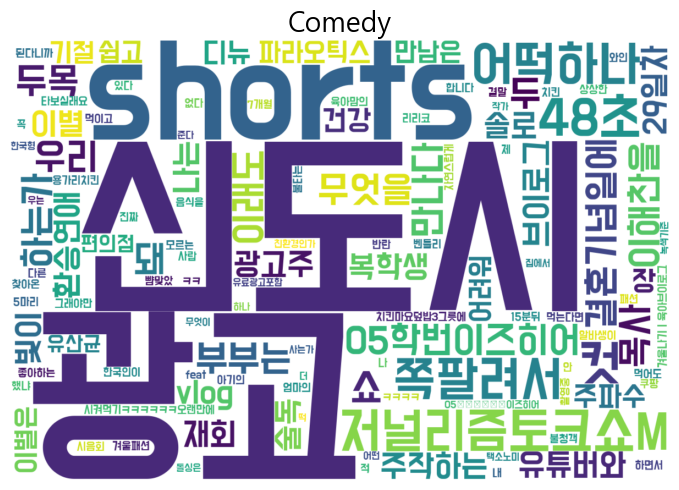

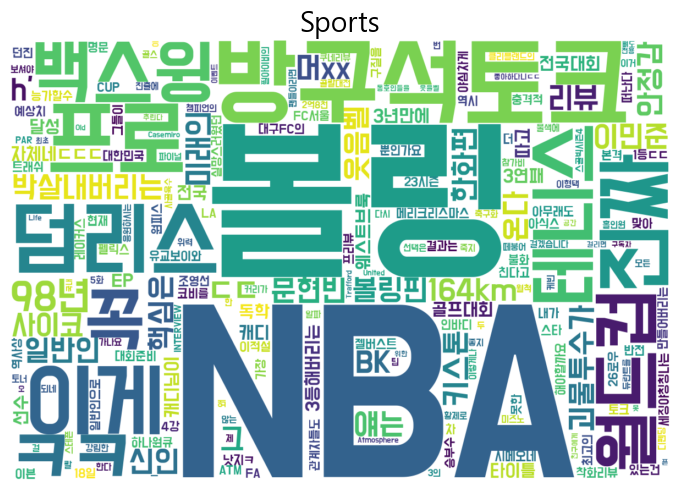

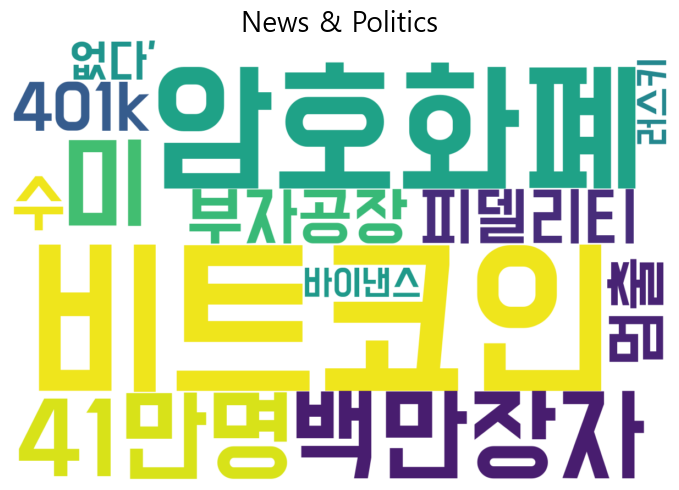

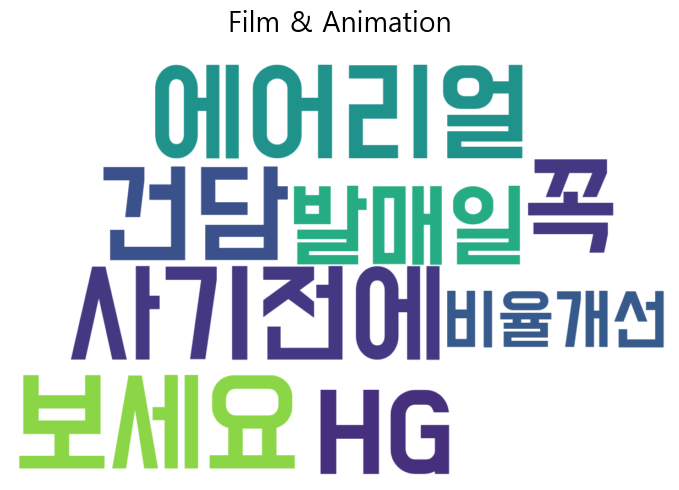

In [80]:
# 장르 별, 유료광고영상 word cloud
plot_wordcloud(good_ad_df, 'title', font_path='BMDOHYEON_ttf.ttf')

In [44]:
# 형태소 분석하여, 제목을 토큰화 하는 함수
def tokenize(text):
    if pd.isna(text):
        return None
    okt = Okt()
    stopwords = ['/', '[', ']', '+', '-', '_', '=', '(', ')', '{', '}',
                 '>', '<', ':', ';', '.', ',', '?', '!', '@', '#', '$',
                 '%', '^', '&', '*', '...','"', "''"]
    
    words = okt.pos(text)
    # 품사 태그 선택
#     words = [word for word, pos in words if pos not in ['Josa', 'Determiner', 'Conjunction',
#                                                         'Eomi', 'PreEomi','Punctuation', 'Unknown', 'Number']]
    words = [word for word, pos in words if pos in ['Noun', 'Adjective', 'Verb', 'Adverb']]
    # 불용어 제거
    words = [word for word in words if word not in stopwords] 
    
    return words

In [61]:
# 'title_token' 컬럼 추가
good_ad_df = good_ad_df.copy()
good_ad_df['title_token'] = good_ad_df['title'].apply(tokenize)
good_ad_df[['title_token','score']]

title_token      score
0                                         [입주, 나, 오지마]  53.099050
1               [이, 가격, 차, 국산, 차, 잡겠다는, 신형, 가, 대박, 이유]   9.725421
2    [일방, 통행, 직진, 서행, 하는데, 어린, 여자아이, 갑자기, 튀어나와서, 교통...   5.615801
3                  [남자친구, 번, 반하는, 쌩얼, 메이크업, 필수, 템, 추천]   4.301910
4    [차갑, 포함, 종보, 통, 면허, 운전, 가능, 가격, 참, 놀랍네요, 국내, 최...   4.213588
..                                                 ...        ...
486        [리니지, 발록, 오, 적혈, 공성, 선, 포함, 용느사, 조직, 뮨, 법사]   0.542581
487  [요즘, 근황, 필라테스, 질린, 썰, 독감, 주사, 맞고, 가로수길, 쇼핑, 혼밥...   0.541564
488  [오딘, 발할라, 라이, 징, 신라, 젠, 주님, 기적, 같은, 도전, 꿈, 이루어...   0.541269
489  [강아지, 사료, 비타, 파우, 연어, 크릴, 기호, 좋은, 소프트, 사료, 풍부한...   0.538425
490                                 [첫, 눈, 그, 설렘을, 안고]   0.538407

[491 rows x 2 columns]

In [46]:
def calculate_token_scores(df, text_feature):
    # 각 토큰 별로 score 값을 저장할 딕셔너리 생성
    token_scores = defaultdict(list)

    # df의 각 행을 순회하면서
    for idx, row in df.iterrows():
        tokens = row[text_feature]  # 해당 행의 토큰 리스트를 가져옴
        score = row['score']  # 해당 행의 score 값을 가져옴
        # 토큰이 None이면 무시
        try:
            for token in tokens:  
                token_scores[token].append(score)  # 해당 토큰의 score 리스트에 현재 score 추가
        except:
            continue

    # 각 토큰 별로 score의 평균을 계산
    token_avg_scores = {token: sum(scores) / len(scores) for token, scores in token_scores.items()}
    df_token_scores = pd.DataFrame(list(token_avg_scores.items()), columns=['Token', 'Average Score'])
    df_token_scores.sort_values('Average Score', ascending=False, inplace=True)
    df_token_scores.reset_index(drop=True, inplace=True)
    return df_token_scores

In [47]:
calculate_token_scores(good_ad_df, 'title_token')

Token  Average Score
0       입주      53.099050
1      오지마      53.099050
2       국산       9.725421
3     잡겠다는       9.725421
4        나       5.723171
...    ...            ...
2976    파우       0.538425
2977    비타       0.538425
2978   강아지       0.538425
2979   설렘을       0.538407
2980    안고       0.538407

[2981 rows x 2 columns]

In [152]:
calculate_token_scores(good_ad_df, 'thumbnail_text_token')

Token  Average Score
0       톰슨       5.615801
1     블랙박스       5.615801
2       일방       5.615801
3       통행       5.615801
4       쌩얼       4.301910
...    ...            ...
2453     네       0.538425
2454     편       0.538425
2455   급하게       0.538425
2456    사료       0.538425
2457    순간       0.538407

[2458 rows x 2 columns]

### 영상 제목 토큰의 빈도 수

In [48]:
df_token_scores = calculate_token_scores(good_ad_df, 'thumbnail_text_token')

KeyError: 'thumbnail_text_token'

<Figure size 1000x500 with 0 Axes>

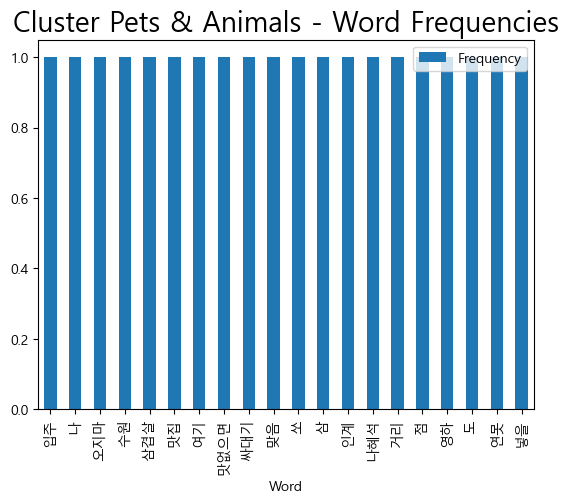

       Average Score
Token               
입주         53.099050
나           5.723171
오지마        53.099050
수원          0.662655
삼겹살         0.633650
맛집          1.402915
여기          2.156174
맛없으면        0.662655
싸대기         0.662655
맞음          0.736315
쏘           0.662655
삼           0.662655
인계          0.662655
나혜석         0.662655
거리          0.763619
점           0.824681
영하          0.877018
도           0.657390
연못          0.657390
넣을          0.657390


<Figure size 1000x500 with 0 Axes>

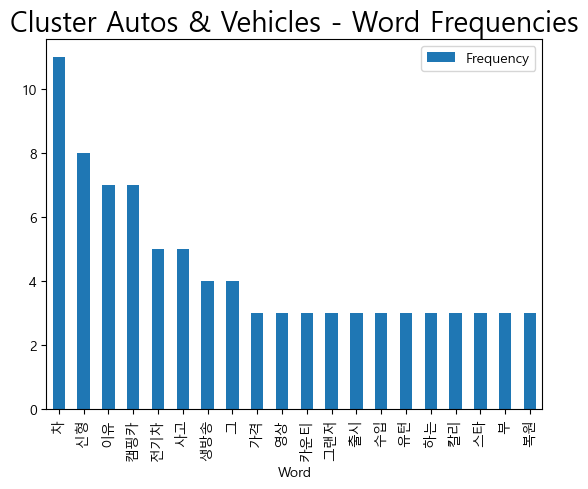

       Average Score
Token               
차           2.502974
신형          1.925948
이유          1.546597
캠핑카         2.502624
전기차         1.154700
사고          1.073013
생방송         1.030362
그           1.138295
가격          2.673015
영상          2.639462
카운티         4.213588
그랜저         1.621664
출시          0.934387
수입          1.199139
유턴          0.766562
하는          0.941475
칼리          0.937076
스타          0.903144
부           0.978947
복원          0.937076


<Figure size 1000x500 with 0 Axes>

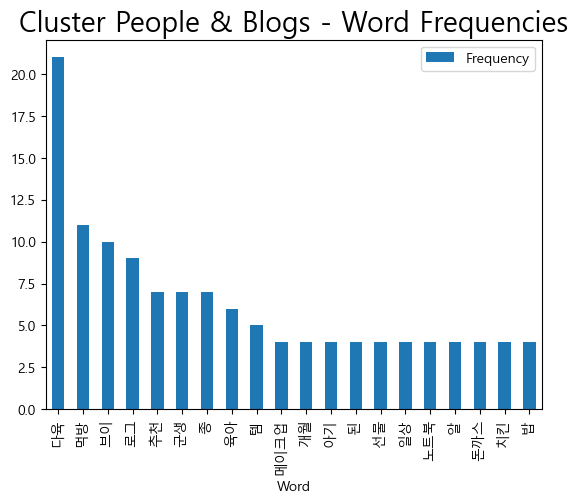

       Average Score
Token               
다육          0.953136
먹방          0.931673
브이          1.383596
로그          1.407179
추천          1.414498
군생          0.868960
종           0.928082
육아          1.395049
템           1.007955
메이크업        1.629132
개월          1.702724
아기          1.972105
된           1.061196
선물          0.832058
일상          0.771683
노트북         0.962343
알           0.704509
돈까스         0.663610
치킨          0.813246
밥           1.043514


<Figure size 1000x500 with 0 Axes>

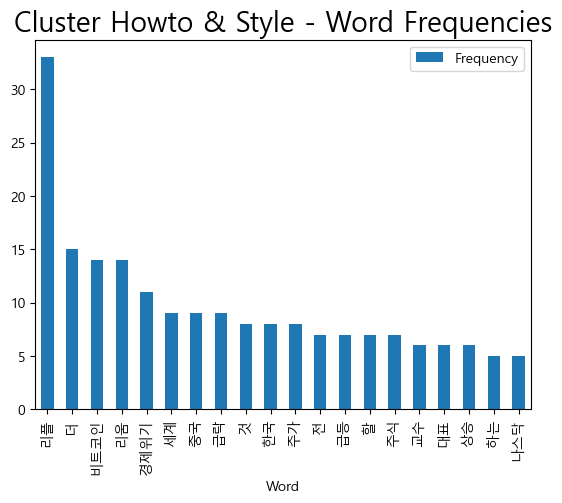

       Average Score
Token               
리플          0.935750
더           0.930069
비트코인        0.954989
리움          0.936187
경제위기        1.520041
세계          1.078251
중국          1.046952
급락          1.174510
것           1.390530
한국          1.052962
주가          1.071221
전           1.057511
급등          1.005888
할           1.156322
주식          0.926428
교수          1.573194
대표          0.912679
상승          1.077891
하는          0.941475
나스닥         1.388108


<Figure size 1000x500 with 0 Axes>

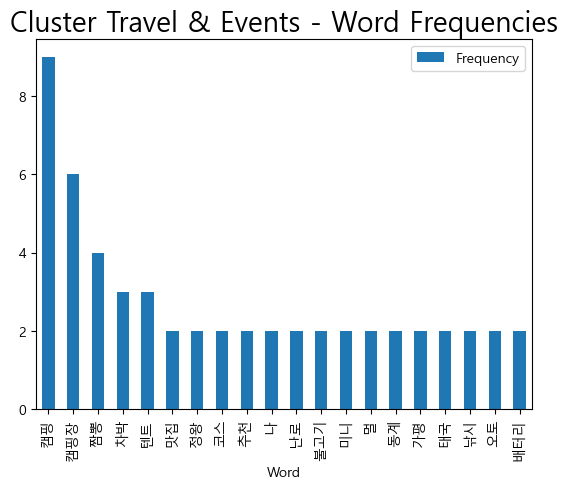

       Average Score
Token               
캠핑          1.387915
캠핑장         0.976885
짬뽕          1.308803
차박          1.271382
텐트          1.056950
맛집          1.402915
정왕          1.437039
코스          1.246222
추천          1.414498
나           5.723171
난로          1.263635
불고기         1.248700
미니          0.870113
멀           0.870113
동계          0.893987
가평          1.033997
태국          0.720269
낚시          0.769643
오토          0.706279
배터리         0.630349


<Figure size 1000x500 with 0 Axes>

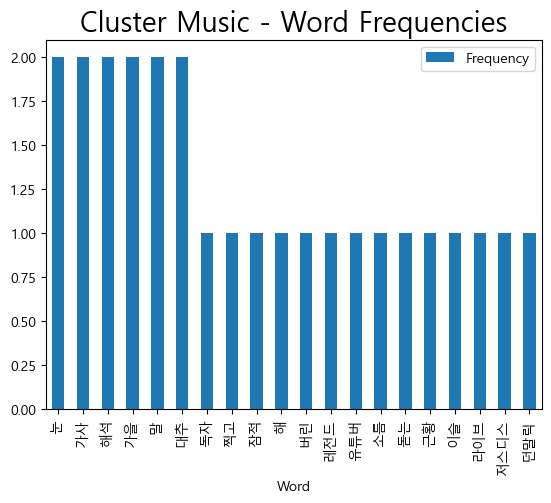

       Average Score
Token               
눈           1.885185
가사          1.237292
해석          1.237292
가을          0.870165
말           1.117503
대추          0.849375
독자          1.419311
찍고          2.173610
잠적          3.667278
해           1.812637
버린          2.484808
레전드         1.399275
유튜버         2.429169
소름          3.667278
돋는          3.667278
근황          2.104421
이슬          2.874380
라이브         1.606003
저스디스        2.874380
던말릭         2.874380


<Figure size 1000x500 with 0 Axes>

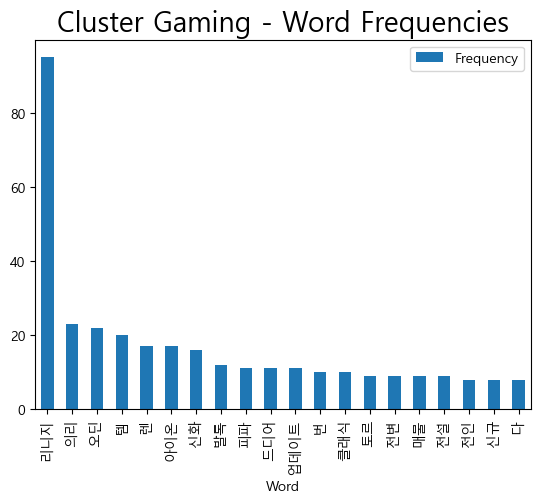

       Average Score
Token               
리니지         1.083945
의리          0.972182
오딘          0.817873
템           1.007955
렌           1.092256
아이온         0.970588
신화          1.500634
발록          0.918769
피파          1.379670
드디어         1.275210
업데이트        0.891221
번           1.234162
클래식         0.915055
토르          0.958735
전변          0.958735
매물          0.958735
전설          1.019768
전인          0.963996
신규          1.002623
다           1.020580


<Figure size 1000x500 with 0 Axes>

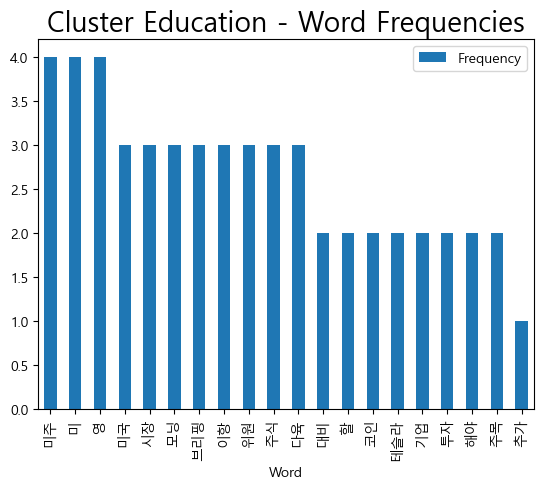

       Average Score
Token               
미주          1.213394
미           1.085461
영           0.759611
미국          1.550093
시장          1.728905
모닝          0.792579
브리핑         0.792579
이항          0.792579
위원          0.792579
주식          0.926428
다육          0.953136
대비          2.439145
할           1.156322
코인          1.120571
테슬라         1.311411
기업          0.708711
투자          0.808863
해야          0.832436
주목          0.622139
추가          1.901710


<Figure size 1000x500 with 0 Axes>

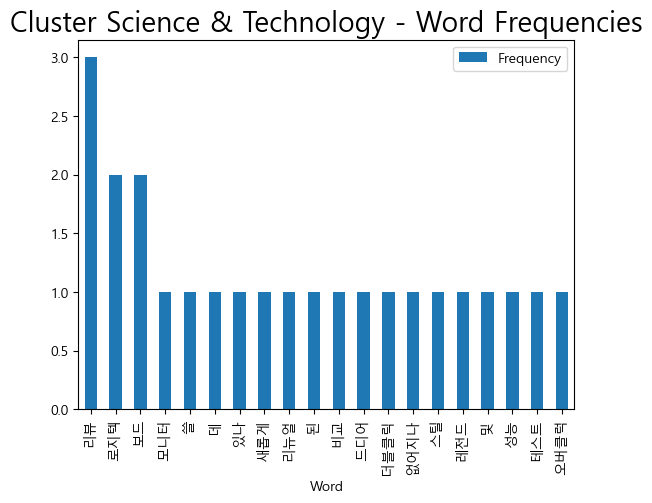

       Average Score
Token               
리뷰          1.061458
로지텍         1.690741
보드          1.231881
모니터         2.592834
쓸           2.592834
데           1.094205
있나          2.592834
새롭게         1.193818
리뉴얼         1.690741
된           1.061196
비교          1.326542
드디어         1.275210
더블클릭        1.690741
없어지나        1.690741
스틸          1.569819
레전드         1.399275
및           1.245485
성능          1.816892
테스트         1.137813
오버클럭        1.569819


<Figure size 1000x500 with 0 Axes>

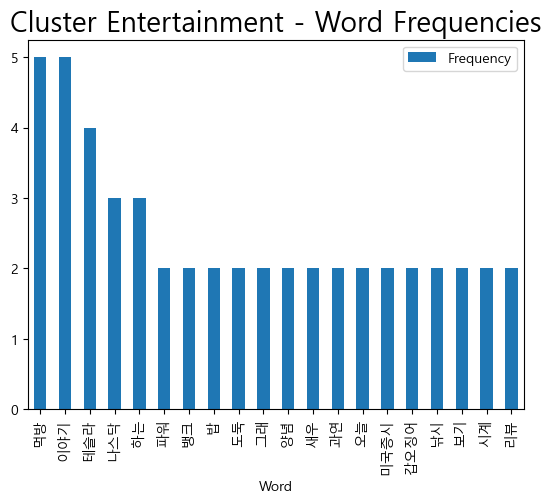

       Average Score
Token               
먹방          0.931673
이야기         0.587135
테슬라         1.311411
나스닥         1.388108
하는          0.941475
파워          1.967801
뱅크          1.967801
밥           1.043514
도둑          2.510961
그래          1.800231
양념          2.510961
새우          1.581119
과연          1.178639
오늘          0.960568
미국증시        1.411471
갑오징어        0.959384
낚시          0.769643
보기          1.400508
시계          0.847475
리뷰          1.061458


<Figure size 1000x500 with 0 Axes>

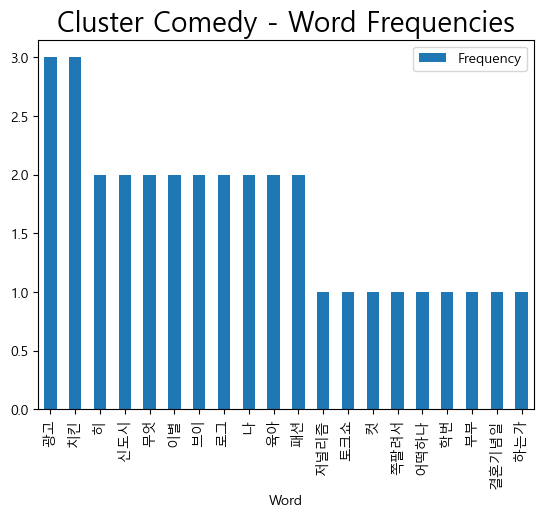

       Average Score
Token               
광고          0.890595
치킨          0.813246
히           0.931292
신도시         0.931292
무엇          0.820950
이별          1.043305
브이          1.383596
로그          1.407179
나           5.723171
육아          1.395049
패션          0.795335
저널리즘        2.301384
토크쇼         2.301384
컷           2.301384
쪽팔려서        2.301384
어떡하나        2.301384
학번          1.297164
부부          1.536875
결혼기념일       1.297164
하는가         1.297164


<Figure size 1000x500 with 0 Axes>

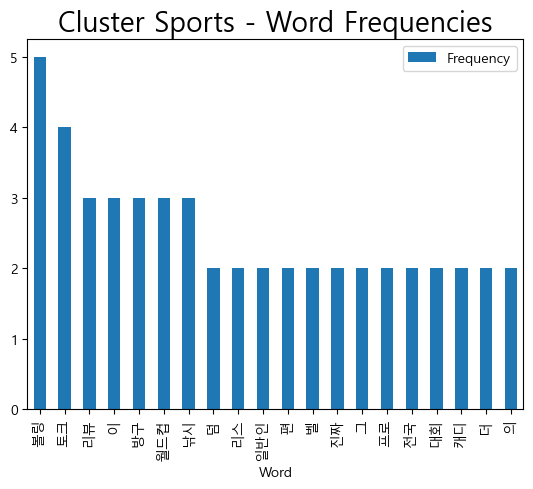

       Average Score
Token               
볼링          1.123110
토크          0.783816
리뷰          1.061458
이           1.504284
방구          0.694487
월드컵         0.991252
낚시          0.769643
덤           1.717033
리스          1.717033
일반인         1.606565
편           1.128965
벨           1.029082
진짜          1.108941
그           1.138295
프로          0.877788
전국          1.104806
대회          1.097452
캐디          1.069411
더           0.930069
의           1.093114


<Figure size 1000x500 with 0 Axes>

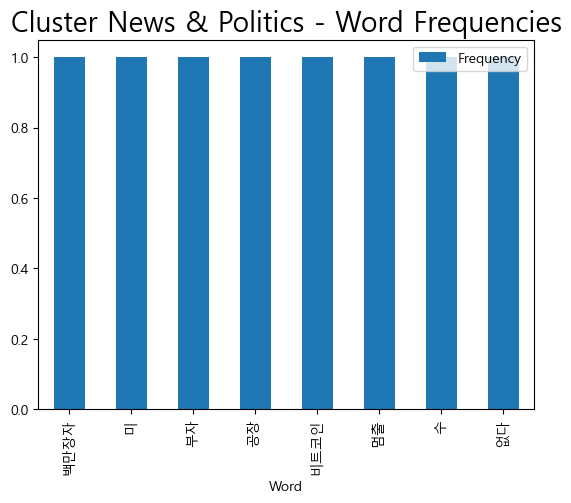

       Average Score
Token               
백만장자        1.088395
미           1.085461
부자          1.117863
공장          1.088395
비트코인        0.954989
멈출          0.951054
수           1.181577
없다          0.870761


<Figure size 1000x500 with 0 Axes>

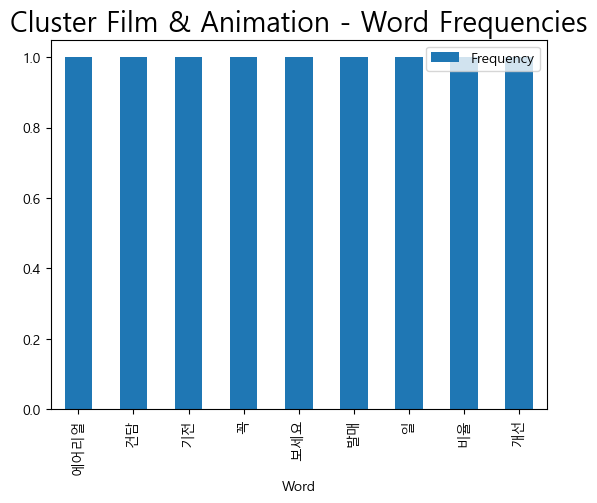

       Average Score
Token               
에어리얼        0.744795
건담          0.744795
기전          0.744795
꼭           0.886919
보세요         1.043923
발매          0.744795
일           0.836549
비율          0.744795
개선          1.210692


In [40]:
plt.rc('font', family='Malgun Gothic')
okt = Okt()

# 불용어 리스트 생성
stopwords = ['/', '[', ']', '+', '-', '_', '=', '(', ')', '{', '}',
             '>', '<', ':', ';', '.', ',', '?', '!', '@', '#', '$', '%', '^', '&', '*', '...','"', "''"]
df_token_scores.set_index('Token', inplace=True)
for i in good_ad_df['genre'].unique():
    # 해당 클러스터의 데이터만 선택
    cluster_data = good_ad_df[good_ad_df['genre'] == i]

    # 'title' 열의 모든 텍스트를 하나의 문자열로 합침
    text = ' '.join(cluster_data['title'])

    # 형태소 분석 후 명사와 형용사만 추출
    words = okt.pos(text)
#     words = [word for word, pos in words if pos not in ['Josa', 'Determiner', 'Conjunction',
#                                                         'Eomi', 'PreEomi','Punctuation', 'Unknown', 'Number']]
    words = [word for word, pos in words if pos in ['Noun', 'Adjective', 'Verb', 'Adverb']]
    words = [word for word in words if word not in stopwords] # stopwords에 포함되지 않은 단어만 선택

    # 단어의 빈도수 계산
    word_freq = Counter(words)

    # 상위 20개 단어만 선택
    top_20 = word_freq.most_common(20)

    # 데이터프레임 생성
    word_df = pd.DataFrame(top_20, columns=['Word', 'Frequency'])

    # 막대 그래프 그리기
    plt.figure(figsize=(10, 5))
    word_df.plot(kind='bar', x='Word', y='Frequency')
    plt.xticks(rotation=90)
    plt.title(f'Cluster {i} - Word Frequencies', fontsize=20)
    plt.show()
    
    # top_20에 해당하는 토큰들의 평균 점수 출력
    print(df_token_scores.loc[word_df['Word']])


---

# 유료 광고 영상 썸네일 분석
    - Using Google cloud vision API

In [89]:
# # API KEY 설정
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'adanalysis-388310-4f2f9b76ca17.json'

# # 클라이언트 초기화
# client = vision.ImageAnnotatorClient()

In [90]:
# 썸네일 url 재설정해서 새로운 피쳐로 추가
def get_thumbnail_url(video_url):
    video_id = video_url.split('watch?v=')[-1]
    thumbnail_url = f"https://img.youtube.com/vi/{video_id}/0.jpg"
    return thumbnail_url

In [91]:
# thumbnail 변수 재생성 (기존에 이미지가 누락된 것들이 많아서)
good_ad_df['thumbnail'] = good_ad_df['video_url'].apply(get_thumbnail_url)
# 기존 썸네일 피쳐 삭제
good_ad_df.drop(columns='video_thumbnails_url', axis=1, inplace=True)

In [37]:
no_thumbnail_lst= []
# 썸네일이 없는 이미지는 NA 값으로 처리
for index in range(len(good_ad_df)):
    try:
        urlopen(good_ad_df['thumbnail'][index]).read()
    except:
        no_thumbnail_lst.append(index)
        good_ad_df.loc[index, 'thumbnail'] = None
        print('na로 대체: ', index)

na로 대체:  0
na로 대체:  19
na로 대체:  59
na로 대체:  76
na로 대체:  97
na로 대체:  101
na로 대체:  103
na로 대체:  106
na로 대체:  133
na로 대체:  134
na로 대체:  287
na로 대체:  328
na로 대체:  363
na로 대체:  434
na로 대체:  439
na로 대체:  456
na로 대체:  479


In [45]:
# 위 코드는 비용이 커서 아래의 index를 따로 저장하여 Na 값 채움
no_thumbnail_lst = [0, 19, 59, 76, 97, 101, 103, 106, 133, 134, 287, 328, 363, 434, 439, 456, 479]

In [92]:
good_ad_df.loc[no_thumbnail_lst, 'thumbnail'] = None

### 썸네일 이미지를 로컬 환경에 .jpg로 저장
    - Saved as cd\thumbnails\thumbnail_{index}.jpg

In [34]:
# 이미지를 저장할 디렉토리가 없다면, 만들어야 합니다.
if not os.path.exists('thumbnails'):
    os.makedirs('thumbnails')

# 각각의 썸네일 이미지를 가져와 저장하는 함수
def save_thumbnail(thumbnail_url, index):
    try:
        response = requests.get(thumbnail_url)
        img = Image.open(BytesIO(response.content))
        img.save(f'thumbnails/thumbnail_{index}.jpg')
    except Exception as e:
        print(f"An error occurred while saving image at {thumbnail_url}: {e}")

# 'thumbnail' 열에 있는 모든 URL에 대해 위 함수를 적용
for index, thumbnail_url in enumerate(good_ad_df['thumbnail']):
    save_thumbnail(thumbnail_url, index)

### Object Detection

In [97]:
def detect_objects(image_url):
    # url이 na값이면
    if pd.isna(image_url):
        return None
    
    image = vision.Image()
    image.source.image_uri = image_url
    response = client.object_localization(image=image)

    objects = response.localized_object_annotations
    # obj의 name 만 리스트로 저장
    detected_objects = [obj.name for obj in objects if obj.score >= 0.5]

    return detected_objects

### Label Detection

In [98]:
def detect_labels(image_url):
    # url이 na값이면
    if pd.isna(image_url):
        return None

    image = vision.Image()
    image.source.image_uri = image_url
    response = client.label_detection(image=image)

    labels = response.label_annotations
    # label의 description 부분만 리스트로 저장
    detected_labels = [label.description for label in labels]

    return detected_labels

In [99]:
# good_ad_df['thumbnail_labels'] = good_ad_df['thumbnail'].apply(detect_labels)

### Dominant Colors of thumbnail

In [102]:
# 썸네일에 사용된 상위 4가지 색을 사용
def get_dominant_colors(image_url):
    global count
    count += 1
    print(count, "")
    # url이 na값이면
    if pd.isna(image_url):
        return None

    image = vision.Image()
    image.source.image_uri = image_url
    response = client.image_properties(image=image)

    colors = response.image_properties_annotation.dominant_colors.colors
    # (r,g,b) 값을 튜플로 각각 저장
    dominant_colors = [(color.color.red, color.color.green, color.color.blue) for color in colors]

    # 상위 4가지 r,g,b 값 반환
    return dominant_colors[:4]

In [108]:
# count = 0
# good_ad_df['thumbnail_colors'] = good_ad_df['thumbnail'].apply(get_dominant_colors)

### Text Detection
    - 썸네일에 사용된 text와 영상에서 썸네일이 차지하는 비율(0~1)

In [104]:
def detect_text_and_area_ratio(image_url):
    """Detects text in the image and calculates text area ratio."""
    global count
    print(count)
    count += 1
    # 이미지 URL이 na값이면 pass
    # url이 na값이면
    if pd.isna(image_url):
        return None, None

    # 이미지 다운로드
    response = requests.get(image_url)
    image = vision.Image(content=response.content)

    # text_detection API 사용
    response = client.text_detection(image=image)
    texts = response.text_annotations

    # 첫 번째 요소는 전체 텍스트를 포함하므로 이를 따로 저장
    all_text = texts[0].description if texts else ""

    total_area = 0
    for text in texts[1:]:
        vertices = [(vertex.x, vertex.y)
                    for vertex in text.bounding_poly.vertices]
        width = vertices[1][0] - vertices[0][0]
        height = vertices[2][1] - vertices[0][1]
        area = width * height
        # text들의 영역을 누적
        total_area += area
    # 텍스트가 없으면 비율은 0
    if total_area == 0:  
        return all_text, 0

    # texts[0]의 꼭짓점은 전체 크기에 해당
    img_width = texts[0].bounding_poly.vertices[1].x
    img_height = texts[0].bounding_poly.vertices[2].y
    img_area = img_width * img_height
    ratio = total_area / img_area
    ratio = round(ratio, 2)
    return all_text, ratio

# apply 하기 위한 함수
def apply_to_df(row):
    text, ratio = detect_text_and_area_ratio(row['thumbnail'])
    row['thumbnail_text'] = text
    row['thumbnail_text_ratio'] = ratio
    return row

In [164]:
good_ad_df = pd.merge(good_ad_df, df[['video_url', 'tag']], on='video_url', how='left')

In [107]:
# count = 0
# good_ad_df = good_ad_df.apply(apply_to_df, axis=1)

In [168]:
good_ad_df['thumbnail_colors'].str.len().unique()

array([nan,  4.])

In [171]:
good_ad_df['thumbnail_text_token'] = good_ad_df['thumbnail_text'].apply(tokenize)

In [173]:
df_token_scores = calculate_token_scores(good_ad_df, 'thumbnail_text_token')
df_token_scores

Token  Average Score
0       톰슨       5.615801
1     블랙박스       5.615801
2       일방       5.615801
3       통행       5.615801
4       쌩얼       4.301910
...    ...            ...
2453     네       0.538425
2454     편       0.538425
2455   급하게       0.538425
2456    사료       0.538425
2457    순간       0.538407

[2458 rows x 2 columns]

In [77]:
def visualize_color(rgb_values):
    # RGB 값들을 255로 나누어 0~1 사이의 값으로 변환합니다.
    normalized_rgb_values = [value / 255 for value in rgb_values]

    # 변환된 RGB 값을 이용하여 색상을 시각화합니다.
    plt.figure(figsize=(1, 1))
    plt.imshow([[normalized_rgb_values]])
    plt.axis('off')
    plt.show()

In [176]:
good_ad_df.to_csv('good_ad_data.csv', index=False, encoding="utf-8-sig")

In [55]:
good_ad_df = pd.read_csv('good_ad_data.csv')
good_ad_df

video_url  \
0    https://www.youtube.com/watch?v=pMJtqx3x8wY   
1    https://www.youtube.com/watch?v=G0n3MTdcqKs   
2    https://www.youtube.com/watch?v=v9is7pn3W_w   
3    https://www.youtube.com/watch?v=QJFILWNHbpY   
4    https://www.youtube.com/watch?v=mosfTVw7cvA   
..                                           ...   
486  https://www.youtube.com/watch?v=7Rddy1fI9Wg   
487  https://www.youtube.com/watch?v=knTs4Qa-a00   
488  https://www.youtube.com/watch?v=_Pykje7Wfqo   
489  https://www.youtube.com/watch?v=n-X68M_PYvc   
490  https://www.youtube.com/watch?v=3rT8xqOL1PQ   

                                                 title  \
0                                   한입주께...나한테 오지마ㅋㅋㅋㅋ   
1           이 가격에 이런차를??! 국산차까지 잡겠다는 신형 SUV가 대박이라는 이유!   
2    일방통행 직진 서행하는데 어린 여자아이가 갑자기 튀어나와서 교통사고 날뻔했어요 블랙...   
3          ♡˚ ‧｡♥｡남자친구가 2번 반하는 쌩얼st 메이크업 필수템 추천♡˚ ‧｡♥｡   
4    차갑포함 3천만원대 1종보통면허 운전가능?!!  가격 참 놀랍네요~ 국내최대 버스캠...   
..                                                 ...   
486                 [리니지M] 발록5  오 적혈공성선포함 ㄷㄷ 용느사조직 뮨법사   
487  요즘 근황(필라테스 질린 썰?) | 독감주사 맞고 가로수길 쇼핑하고 혼밥 | 불꽃놀...   
488     [오딘 : 발할라 라이징] 3억 신라젠 주주님 기적같은 도전 / 꿈은 이루어 집니다   
489    강아지사료 비타파우 연어크릴 기호성좋은 소프트사료 풍부한 육즙 말랑말랑 식감이 있어요   
490                          [playlist] 첫 눈, 그 설렘을 안고서   

                   channel_id    views    likes publishDate             genre  \
0    UCn59UWMhtPvaRKyZxmBbmgA  2001197  13416.0  2022-12-01    Pets & Animals   
1    UCCbLQtdzoIJB-Ah6_oWFsoA  2137171   3457.0  2022-11-12  Autos & Vehicles   
2    UCjdtJTIpHyfSnt4_7hjptdg     5189      3.0  2022-10-07  Autos & Vehicles   
3    UCRH6Eng69qsXTlSoSzgzTkQ   227257    151.0  2022-12-11    People & Blogs   
4    UCpdI_QukHzpEy6xPaEPCP5Q   355610    283.0  2022-10-25  Autos & Vehicles   
..                        ...      ...      ...         ...               ...   
486  UCPyFrasQFig_vS-A9-yrbUw     3931    117.0  2022-09-25            Gaming   
487  UC3H6AXUcPH0hjFr1m9jkB8Q    12554      0.0  2022-10-17    People & Blogs   
488  UCEqnhWFiZV-ziHD909994gQ    13627     74.0  2022-09-11            Gaming   
489  UCdTWLop6vWTFh0IF9TXRGJA     3370      0.0  2023-02-05    People & Blogs   
490  UCweFCeE7R38-pvPl6RifWpw   334104   1418.0  2022-12-01             Music   

     ads_yn       tag1  subscribers  ...      score  duration_min  \
0         1         동물      18600.0  ...  53.099050          0.12   
1         1        자동차     203000.0  ...   9.725421          5.27   
2         1        자동차       7660.0  ...   5.615801          0.17   
3         1  뷰티 & 메이크업     130000.0  ...   4.301910          9.13   
4         1        자동차     133000.0  ...   4.213588         28.83   
..      ...        ...          ...  ...        ...           ...   
486       1         게임      22800.0  ...   0.542581        200.08   
487       1       피트니스      26200.0  ...   0.541564         23.58   
488       1         게임     103000.0  ...   0.541269         14.92   
489       1        강아지       5230.0  ...   0.538425          3.83   
490       1         음악     666000.0  ...   0.538407         78.92   

                                           title_token  \
0                                   ['입주', '나', '오지마']   
1    ['이', '가격', '차', '국산', '차', '잡겠다는', '신형', '가',...   
2    ['일방', '통행', '직진', '서행', '하는데', '어린', '여자아이', ...   
3    ['남자친구', '번', '반하는', '쌩얼', '메이크업', '필수', '템', ...   
4    ['차갑', '포함', '종보', '통', '면허', '운전', '가능', '가격'...   
..                                                 ...   
486  ['리니지', '발록', '오', '적혈', '공성', '선', '포함', '용느사...   
487  ['요즘', '근황', '필라테스', '질린', '썰', '독감', '주사', '맞...   
488  ['오딘', '발할라', '라이', '징', '신라', '젠', '주님', '기적'...   
489  ['강아지', '사료', '비타', '파우', '연어', '크릴', '기호', '좋...   
490                       ['첫', '눈', '그', '설렘을', '안고']   

                                        thumbnail  \
0                                             NaN   
1    https://img.youtube.com/vi/G0n3MTdcqKs/0.jpg   
2    https://img.youtube.com/vi/v9is7pn3W_w/0.jpg   
3    h

In [54]:
good_ad_df['genre'].nunique()

14

In [57]:
print(os.getcwd())

C:\Users\7info\Desktop\Content_Evaluation
